Usecase test 3: Can links be found relating to predispositions for ASD co-morbidities?

1. Take count of genes cited in the data across all articles highlighting the most cited overall (by most connections)

In [1]:
import rdflib

filename = "cleaned_maingraph.nt"
g = rdflib.Graph()
g.parse(filename, format="nt")

<Graph identifier=Nb288d67e1fe34599aa5a5d5f7da98b44 (<class 'rdflib.graph.Graph'>)>

In [2]:
count_query = """
    PREFIX EDAM: <http://edamontology.org/>
    PREFIX RDF: <http://www.w3.org/1999/02/22-rdf-syntax-ns#>
    PREFIX DCT: <http://purl.org/dc/terms/>
    PREFIX BIOLINK: <https://w3id.org/biolink/vocab/>
    PREFIX ENSEMBL: <http://identifiers.org/ensembl/>
    PREFIX NCBIGENE: <http://identifiers.org/ncbigene/>
    PREFIX XSD: <http://www.w3.org/2001/XMLSchema#>

    SELECT ?gene (COUNT(DISTINCT ?root_subject) AS ?count)
    WHERE {
        ?root_subject ?p ?o
        FILTER(STRSTARTS(STR(?root_subject), "https://pubmed.ncbi.nlm.nih.gov/"))
        ?root_subject ?p1 ?intermediate1 .
        ?intermediate1 ?p2 ?intermediate2 .
        ?intermediate2 BIOLINK:Gene ?gene .
        ?intermediate2 EDAM:data_2082 ?value .
        FILTER(DATATYPE(?value) = XSD:double && ?value < 0.05)
    }
    GROUP BY ?gene
    ORDER BY DESC(?count)
    LIMIT 50
"""
results = g.query(count_query)
print("Gene | Count")
print("-----|------")
for row in results:
    gene = str(row['gene'])
    count = int(row['count'].toPython()) 
    print(f"{gene} | {count}")

Gene | Count
-----|------
https://monarchinitiative.org/HGNC:8010 | 8
https://monarchinitiative.org/HGNC:17302 | 8
https://monarchinitiative.org/HGNC:13406 | 8
https://monarchinitiative.org/HGNC:1180 | 8
https://monarchinitiative.org/HGNC:6292 | 8
https://monarchinitiative.org/HGNC:20990 | 8
https://monarchinitiative.org/HGNC:2905 | 8
https://monarchinitiative.org/HGNC:2095 | 8
https://monarchinitiative.org/HGNC:4082 | 8
https://monarchinitiative.org/HGNC:1426 | 8
https://monarchinitiative.org/HGNC:804 | 8
https://monarchinitiative.org/HGNC:1463 | 8
https://monarchinitiative.org/HGNC:4571 | 8
https://monarchinitiative.org/HGNC:13221 | 8
https://monarchinitiative.org/HGNC:6824 | 8
https://monarchinitiative.org/HGNC:5246 | 8
https://monarchinitiative.org/HGNC:3999 | 8
https://monarchinitiative.org/HGNC:23689 | 7
https://monarchinitiative.org/HGNC:10003 | 7
https://monarchinitiative.org/HGNC:29063 | 7
https://monarchinitiative.org/HGNC:7954 | 7
https://monarchinitiative.org/HGNC:19323 | 7

2. Query external Monarch Initiative graph using API using these top-cited genes for related phenotypes 

In [3]:
top_genes = []
for row in results:
    top_genes.append(str(row['gene']))
print(top_genes)

['https://monarchinitiative.org/HGNC:8010', 'https://monarchinitiative.org/HGNC:17302', 'https://monarchinitiative.org/HGNC:13406', 'https://monarchinitiative.org/HGNC:1180', 'https://monarchinitiative.org/HGNC:6292', 'https://monarchinitiative.org/HGNC:20990', 'https://monarchinitiative.org/HGNC:2905', 'https://monarchinitiative.org/HGNC:2095', 'https://monarchinitiative.org/HGNC:4082', 'https://monarchinitiative.org/HGNC:1426', 'https://monarchinitiative.org/HGNC:804', 'https://monarchinitiative.org/HGNC:1463', 'https://monarchinitiative.org/HGNC:4571', 'https://monarchinitiative.org/HGNC:13221', 'https://monarchinitiative.org/HGNC:6824', 'https://monarchinitiative.org/HGNC:5246', 'https://monarchinitiative.org/HGNC:3999', 'https://monarchinitiative.org/HGNC:23689', 'https://monarchinitiative.org/HGNC:10003', 'https://monarchinitiative.org/HGNC:29063', 'https://monarchinitiative.org/HGNC:7954', 'https://monarchinitiative.org/HGNC:19323', 'https://monarchinitiative.org/HGNC:1399', 'ht

In [4]:
import requests
import pandas as pd
from collections import defaultdict

hgnc_ids = [gene.split('/')[-1] for gene in top_genes]
#getting all associations from monarch api
def get_associations(gene_id, association_type):
    api_url = "https://api-v3.monarchinitiative.org/v3/api/association"
    params = {
        "subject": gene_id,
        "predicate": association_type,
        "offset": 0,
        "limit": 100
    }
    try:
        response = requests.get(api_url, params=params)
        response.raise_for_status()
        data = response.json()
        return data.get('items', [])
    except requests.exceptions.RequestException as e:
        print(f"An error occurred: {e}")
        return []

def get_gene_info(gene_id):
    
    #using predicates to return relevant associations
    phenotypes = get_associations(gene_id, "biolink:has_phenotype")
    diseases = get_associations(gene_id, "biolink:gene_associated_with_condition")
    processes = get_associations(gene_id, "biolink:participates_in")
    functions = get_associations(gene_id, "biolink:enables")
    
    return {
        'Phenotypes': [item.get('object_label', 'Unknown') for item in phenotypes],
        'Diseases': [item.get('object_label', 'Unknown') for item in diseases],
        'Biological Processes': [item.get('object_label', 'Unknown') for item in processes],
        'Molecular Functions': [item.get('object_label', 'Unknown') for item in functions]
    }

results = {}
for gene in hgnc_ids:
    results[gene] = get_gene_info(gene)


In [5]:

# Create a summary of shared associations between the given genes (using set to remove duplicates)
shared_associations = defaultdict(lambda: defaultdict(set))
for category in ['Phenotypes', 'Diseases', 'Biological Processes', 'Molecular Functions']:
    all_items = set()
    for gene, data in results.items():
        all_items.update(data.get(category, []))
    
    for item in all_items:
        genes_with_item = set(gene for gene, data in results.items() if item in data.get(category, []))
        if len(genes_with_item) > 1:
            shared_associations[category][item] = genes_with_item

for category, items in shared_associations.items():
    print(f"\n{category}:")
    if items:
        df = pd.DataFrame([(item, ', '.join(sorted(genes))) for item, genes in items.items()], 
                          columns=[category, 'Genes'])
        print(df.to_string(index=False))
    else:
        print("No shared associations found.")

# Print unique associations for each gene
print("\nUnique associations for each gene:")
for gene, data in results.items():
    print(f"\n{gene}:")
    for category, items in data.items():
        unique_items = set(item for item in items if len(shared_associations[category].get(item, [])) <= 1)
        if unique_items:
            print(f"  {category}:")
            for item in sorted(unique_items):
                print(f"    - {item}")
                


Phenotypes:
                                                   Phenotypes                                                                                                                                                                    Genes
                                                     Dystonia                                                                                                                              HGNC:28214, HGNC:3999, HGNC:4082, HGNC:4585
                                               Neonatal onset                                                                                                                                                   HGNC:18866, HGNC:28214
                                          Triphalangeal thumb                                                                                                                                                     HGNC:1943, HGNC:6292
                                               Cryptorchidism  

In [6]:
print(results)

{'HGNC:8010': {'Phenotypes': [], 'Diseases': [], 'Biological Processes': ['Neurexins and neuroligins', 'Neurexins and neuroligins'], 'Molecular Functions': ['cell adhesion molecule binding', 'neuroligin family protein binding', 'signaling receptor activity', 'metal ion binding', 'transmembrane signaling receptor activity', 'cell adhesion molecule binding', 'neuroligin family protein binding', 'metal ion binding']}, 'HGNC:17302': {'Phenotypes': [], 'Diseases': [], 'Biological Processes': ['Post-translational modification: synthesis of GPI-anchored proteins'], 'Molecular Functions': ['protein binding', 'protein binding', 'protein binding', 'protein binding']}, 'HGNC:13406': {'Phenotypes': ['Cerebellar atrophy', 'Global developmental delay', 'Atrophy/Degeneration affecting the brainstem', 'Hyperreflexia', 'Autosomal recessive inheritance', 'Cerebellar hypoplasia', 'Axial hypotonia', 'High, narrow palate', 'Downturned corners of mouth', 'Hypoplasia of the corpus callosum', 'Cerebral atroph

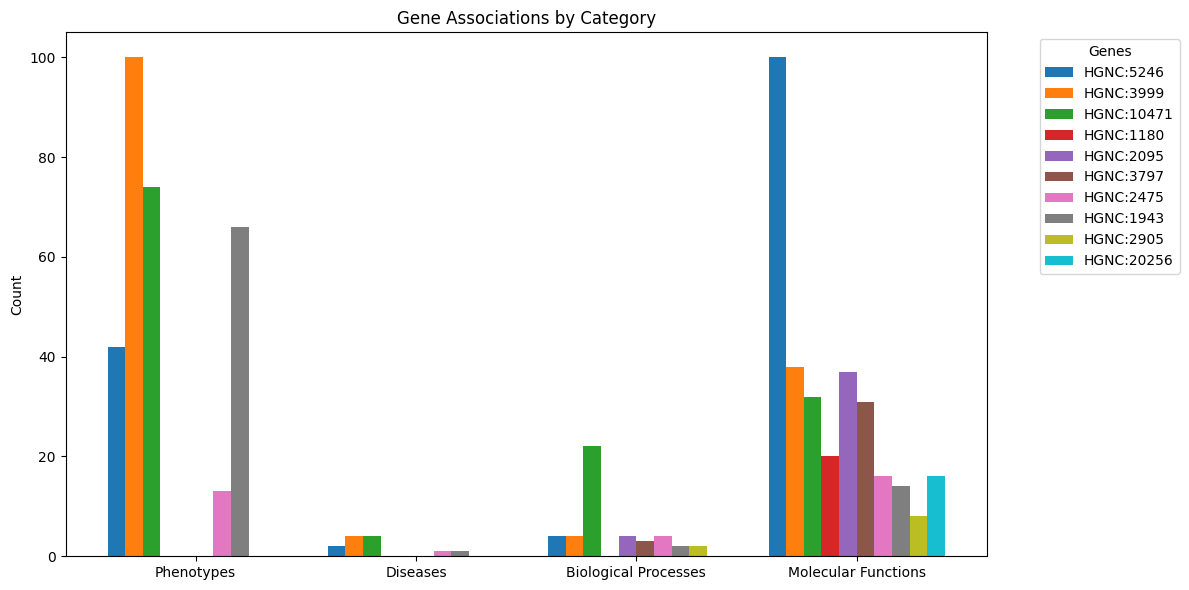

In [16]:
from collections import defaultdict
import numpy as np
import matplotlib.pyplot as plt

counts = defaultdict(lambda: defaultdict(int))
for gene, info in results.items():
    for category, items in info.items():
        counts[category][gene] = len(items)

categories = list(counts.keys())
genes = list(results.keys())
x = np.arange(len(categories))
width = 0.8 / len(genes)

fig, ax = plt.subplots(figsize=(12, 6))
for i, gene in enumerate(genes):
    gene_counts = [counts[category][gene] for category in categories]
    ax.bar(x + i*width, gene_counts, width, label=gene)

ax.set_ylabel('Count')
ax.set_title('Gene Associations by Category')
ax.set_xticks(x + width * (len(genes) - 1) / 2)
ax.set_xticklabels(categories)
ax.legend(title='Genes', bbox_to_anchor=(1.05, 1), loc='upper left')

plt.tight_layout()
plt.show()